In [2]:
import json
import jax.numpy as jnp
import surrojax_gp
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# Plot settings:
mpl.rcParams['figure.dpi'] = 200

In [4]:
def kernel(x_1, x_2, params):
    lengths = jnp.array([params[f"length_{i}"] for i in range(2)])
    inv_lengths = jnp.diag(lengths**(-1))
    ln_k_d = -0.5*(x_1 - x_2).T @ inv_lengths @ (x_1 - x_2) 
    return params["const"]*jnp.exp(ln_k_d)

In [5]:
def plot_function(x, y, z, grid_shape, 
                  z_lims=None, train_pts=None, test_pts=None, title=None, 
                  z_label='Beam Tip Displacement (mm)',
                  num_levels=1000, tick_gap=20):
    
    if z_lims is None:
        z_lims = (jnp.min(z), jnp.max(z))
    levels = jnp.linspace(z_lims[0], z_lims[1], num_levels)
    
    # Reshape inputs:
    x, y, z = x.reshape(grid_shape), y.reshape(grid_shape), z.reshape(grid_shape)
    
    # Create surface plot:
    fig, ax = plt.subplots()
    contour_fig = ax.contourf(x, y, z, levels=levels, cmap='coolwarm')
    ticks = jnp.arange(z_lims[0], z_lims[1]+1, tick_gap)
    cbar = fig.colorbar(contour_fig, ticks=ticks)
    cbar.set_label(z_label, rotation=270, labelpad=15)
    ax.set_xlabel("Young's Modulus (kPa)")
    ax.set_ylabel('Beam Angle (degrees)')
    fig.patch.set_facecolor('white')
    if train_pts is not None:
        plt.plot(train_pts['E'], train_pts['Beam Angle'], 'x', color='black', markersize=3)
    if test_pts is not None:
        plt.plot(test_pts['E'], test_pts['Beam Angle'], 'x', color='green', markersize=3)
    if title is not None:
        ax.set_title(title, pad=15)
    plt.show()

In [6]:
def create_input(data_dict):
    input_array = jnp.stack((jnp.array(data_dict['E']), jnp.array(data_dict['Beam Angle'])), axis=1)
    return input_array

In [7]:
def create_pointgrid(x_lims, y_lims, x_pts, y_pts):
    # Create list of points:
    x_pts = jnp.linspace(x_lims[0], x_lims[1], x_pts)
    y_pts = jnp.linspace(y_lims[0], y_lims[1], y_pts)
    # Create grid of points:
    y_grid, x_grid = jnp.meshgrid(x_pts, y_pts)
    # Store input:
    pts = {'E': x_grid.flatten(), 
           'Angle': y_grid.flatten(), 
           'input': jnp.stack([x_grid.flatten(), y_grid.flatten()], axis=1)}
    return pts 

# Linear Elastic Beam

## Train GP

In [8]:
# Import linear elastic beam data:
train_dir = "./nonlinear_train.json"
test_dir =  "./nonlinear_test.json"
with open(train_dir) as f:
    linear_train = json.load(f)
with open(test_dir) as f:
    linear_test = json.load(f)

In [10]:
# Train Gaussian process model:
constraints = {"length_0": {">": 10**-1, "<": 10**3}, 
               "length_1": {">": 10**-1, "<": 10**3}, 
               "const": {">": 10**-1, "<": 10**3}}
train_features = create_input(linear_train)
train_labels = jnp.array(linear_train['End Displacement']).reshape(-1,1)
gp = surrojax_gp.create_gp(kernel, train_features, train_labels, constraints)

278.50143
267.80405
232.01587
234.09225
234.85559
233.30554
232.01587
232.01587
232.01587
232.01587
232.01587
232.01587
232.01587
232.01587
232.01587
232.01587
232.01587
232.01587
232.01587
232.01587
      fun: array(232.01586914)
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.03613026,  0.16872215, -0.02561893])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 20
      nit: 3
     njev: 20
   status: 0
  success: True
        x: array([435.50516842,  51.9576085 , 551.04099744])
2656.642
2517.02
435.11722
434.5149
417.5308
347.29553
280.76688
258.59164
255.65994
250.12546
246.63351
101221960.0
2890.934
394.70682
260.14926
249.99683
247.5939
246.63351
246.63351
246.63351
246.63351
246.63351
246.63351
246.63351
246.63351
246.63351
246.63351
246.63351
246.63351
246.63351
246.63351
250.18896
248.50076
246.63351
246.63351
246.63351
246.63351
246.63351
246.63351
246.63351
246.63351
246.63351
246.63351
      fun: array(246.6335144)
 hess_in

In [11]:
min_vals, max_vals = jnp.min(train_features, axis=0), jnp.max(train_features, axis=0)
x_lims = [min_vals[1], max_vals[1]]
y_lims = [min_vals[0], max_vals[0]]
x_pts = y_pts = 30
pred_pts = create_pointgrid(x_lims, y_lims, x_pts, y_pts)
gp_pred = gp.predict(pred_pts['input'])

## Plot GP

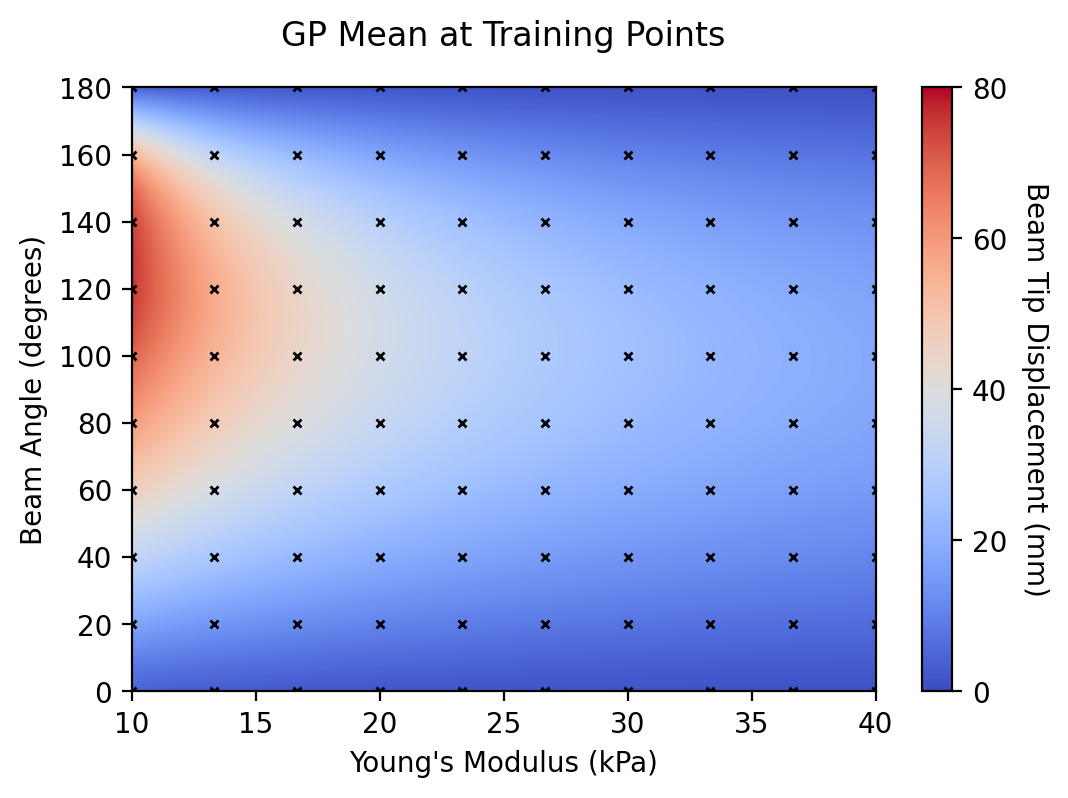

In [12]:
# Plot GP surface:
x_pts = y_pts = 30
grid_shape = (y_pts, x_pts)
title = 'GP Mean at Training Points'
z_lims = (0, 80)
plot_function(pred_pts['E'], pred_pts['Angle'], gp_pred['mean'], grid_shape, 
              train_pts=linear_train, z_lims=z_lims, title=title)

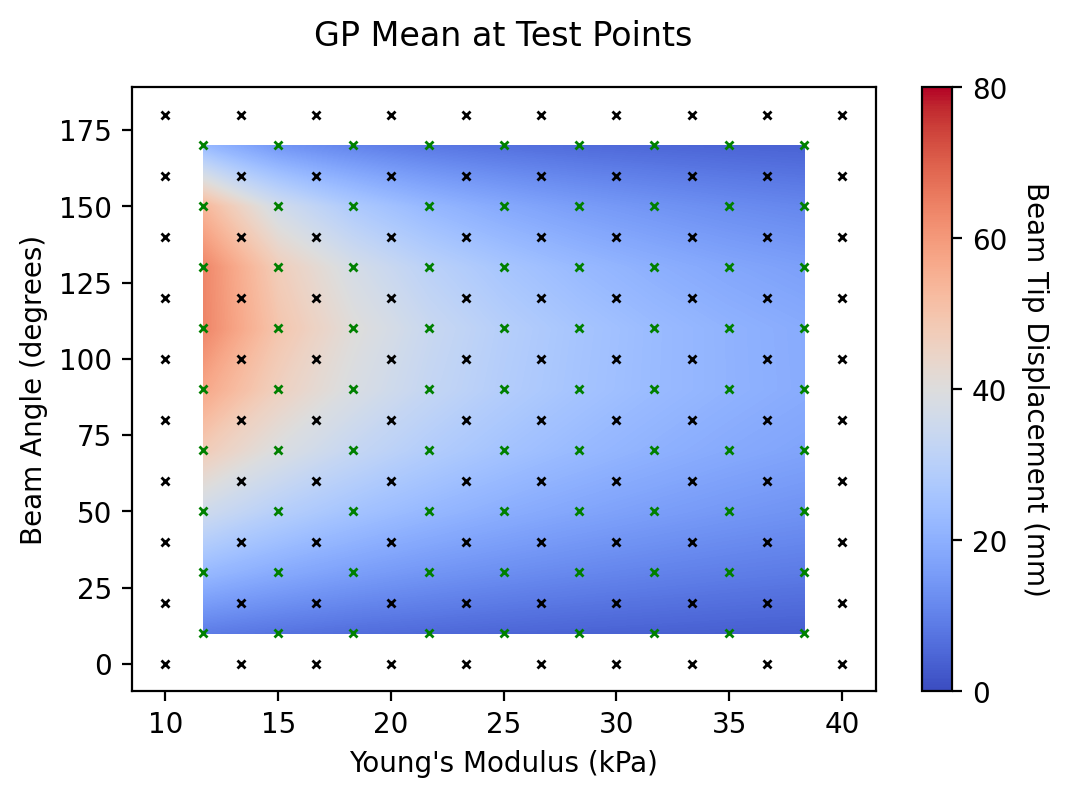

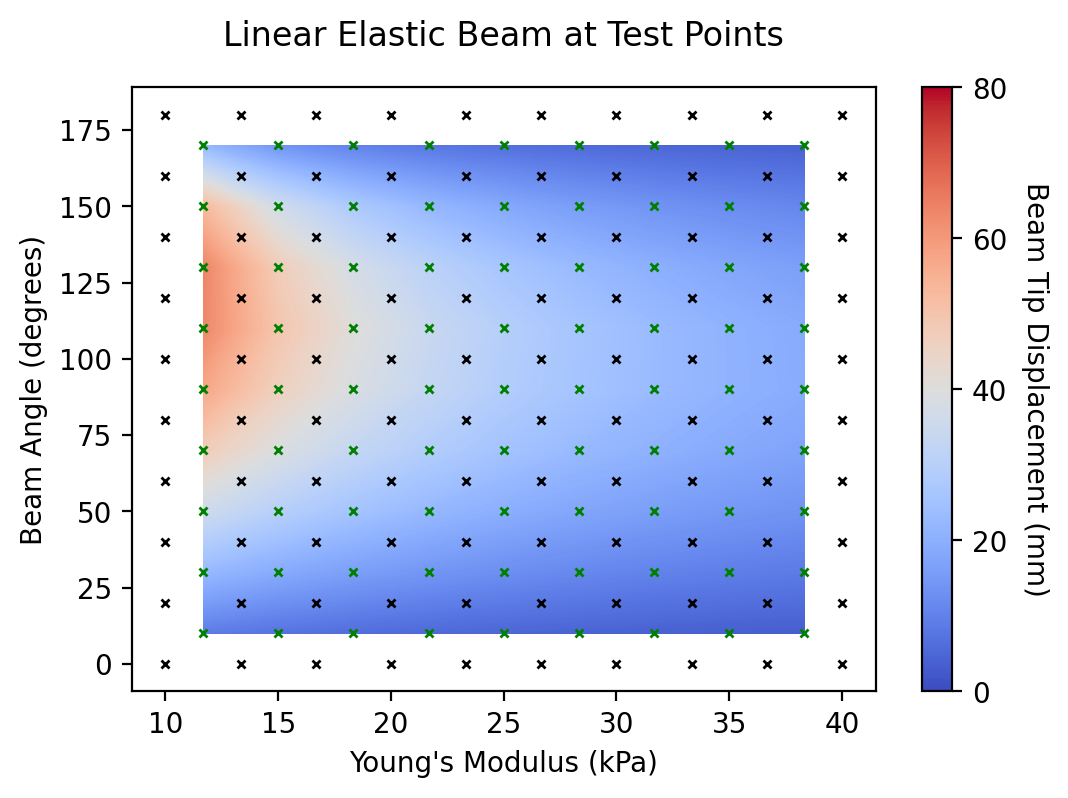

In [13]:
# Compare to test data:
test_features = create_input(linear_test)
grid_shape = (9,9)
gp_pred = gp.predict(test_features)

E_array = jnp.array(linear_test['E'])
angle_array = jnp.array(linear_test['Beam Angle'])
disp_array = jnp.array(linear_test['End Displacement'])

title = 'GP Mean at Test Points'
z_lims = (0, 80)
plot_function(E_array, angle_array, gp_pred['mean'], grid_shape, 
              title=title, z_lims=z_lims, train_pts=linear_train, test_pts=linear_test)
title = 'Linear Elastic Beam at Test Points'
z_lims = (0, 80)
plot_function(E_array, angle_array, disp_array, grid_shape, 
              title=title, z_lims=z_lims, train_pts=linear_train, test_pts=linear_test)

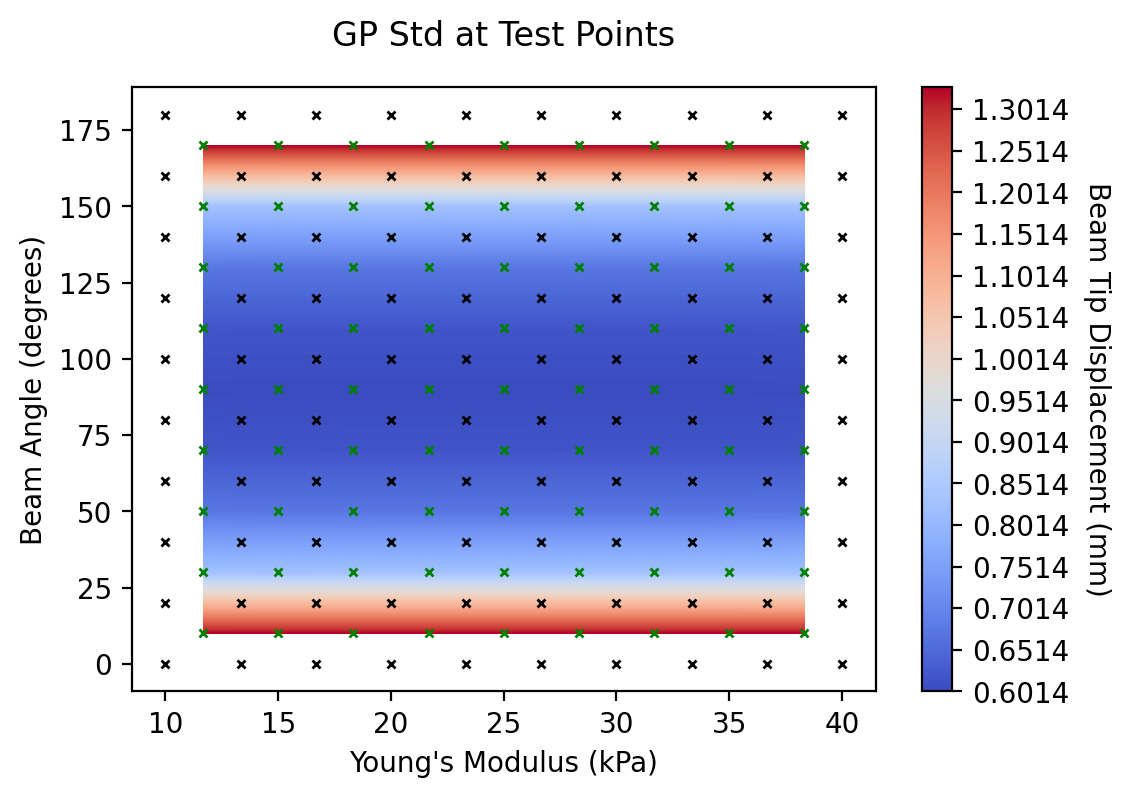

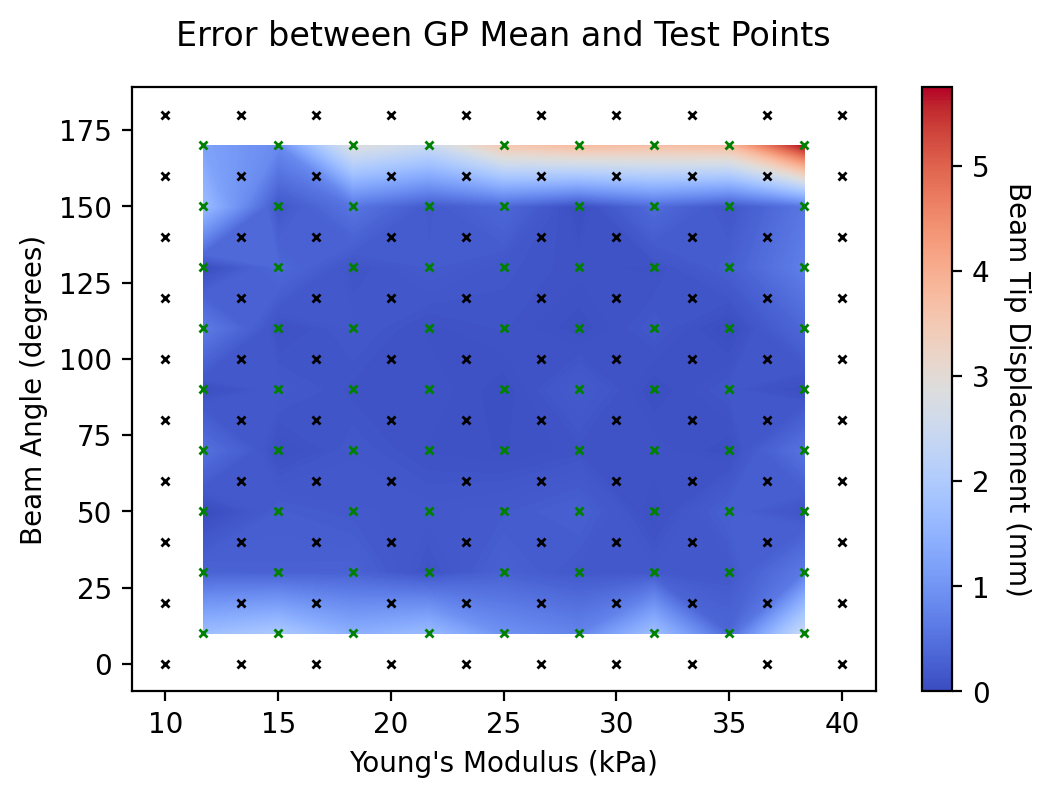

In [21]:
title = 'GP Std at Test Points'
z_label='Std of Beam Tip Displacement (mm)'
z_lims = (0, 0.3)
tick_gap = 0.05
plot_function(E_array, angle_array, gp_pred['var']**0.5, grid_shape, 
              train_pts=linear_train, test_pts=linear_test, title=title, tick_gap=tick_gap)

title = 'Error between GP Mean and Test Points'
z_label='Difference in Beam Tip Displacement (mm)'
# z_lims = (0, 0.9)
tick_gap = 1.0
pct_diff = 100*jnp.abs(disp_array - gp_pred['mean'])/disp_array
plot_function(E_array, angle_array, pct_diff, grid_shape, train_pts=linear_train, test_pts=linear_test, title=title, tick_gap=tick_gap)

In [18]:
100*jnp.abs(disp_array - gp_pred['mean'])/disp_array

DeviceArray([1.68976200e+00, 3.19685340e-01, 1.39144919e-04,
             4.77945507e-01, 4.64562401e-02, 6.23966217e-01,
             1.25864930e-02, 1.66129935e+00, 1.21048415e+00,
             1.93725598e+00, 2.78887480e-01, 2.28251263e-01,
             5.96328750e-02, 1.72246084e-01, 7.17443377e-02,
             3.82132620e-01, 1.36389390e-01, 8.41922760e-01,
             1.40122497e+00, 2.88845658e-01, 1.83041304e-01,
             1.50006965e-01, 1.04987971e-01, 1.62848487e-01,
             1.06103003e-01, 5.37295997e-01, 2.84846330e+00,
             1.63989437e+00, 9.89055336e-02, 1.67742670e-01,
             8.73962194e-02, 1.14497401e-01, 8.32445025e-02,
             2.06235349e-01, 1.86793968e-01, 2.46184826e+00,
             9.37520504e-01, 2.78451622e-01, 1.93807751e-01,
             6.57834932e-02, 4.79840226e-02, 1.18805356e-01,
             1.39384285e-01, 3.54194462e-01, 3.50639272e+00,
             7.40714014e-01, 1.61516502e-01, 2.60847092e-01,
             1.03267528e

## Plot Derivatives of GP

In [84]:
# Mixed derivative:
min_vals, max_vals = jnp.min(train_features, axis=0), jnp.max(train_features, axis=0)
x_lims = [min_vals[1], max_vals[1]]
y_lims = [min_vals[0], max_vals[0]]
x_pts = y_pts = 30
pred_pts = create_pointgrid(x_lims, y_lims, x_pts, y_pts)

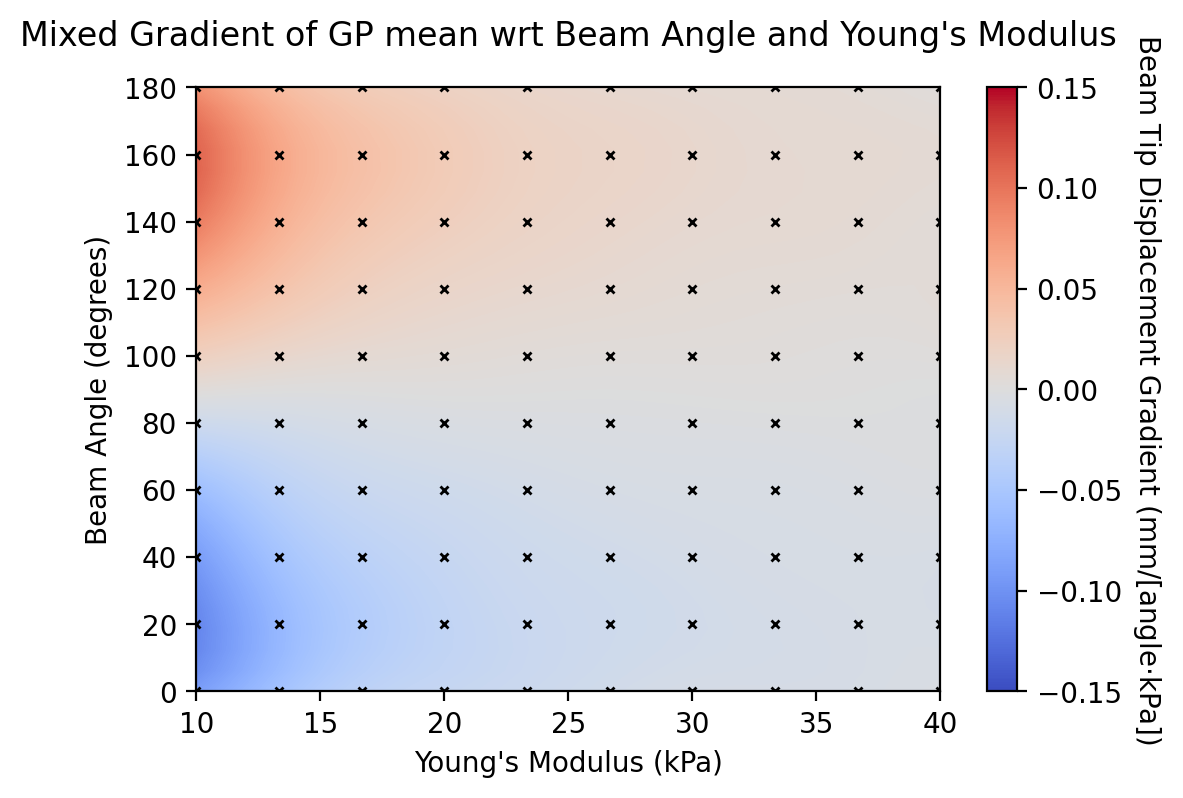

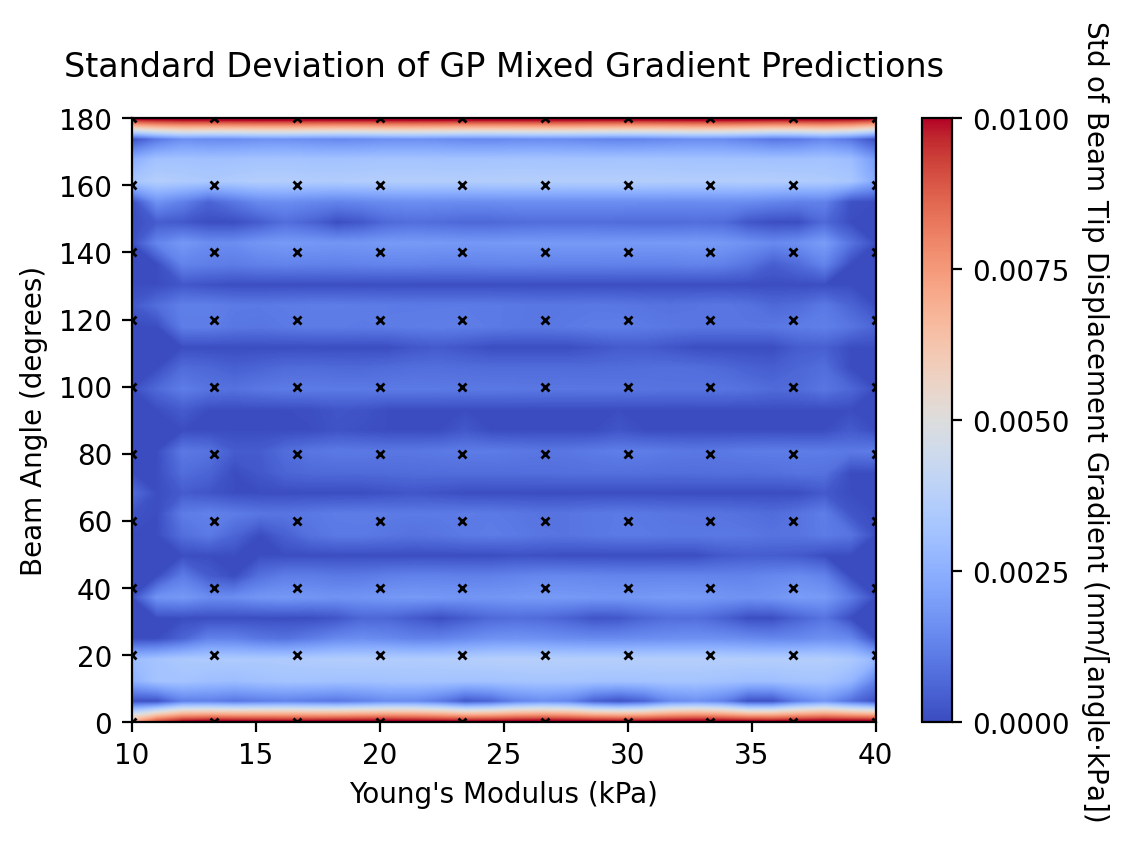

In [94]:
grad = ({'idx': [0], 'order':1}, {'idx': [1], 'order':1})
gp_pred = gp.predict(pred_pts['input'], grad=grad)
grid_shape = (y_pts, x_pts)
title = "Mixed Gradient of GP mean wrt Beam Angle and Young's Modulus"
z_lims=(-0.15, 0.15)
z_label='Beam Tip Displacement Gradient (mm/[angle$\cdot$kPa])'
tick_gap=0.05
plot_function(pred_pts['E'], pred_pts['Angle'], gp_pred['mean'], grid_shape, 
              train_pts=linear_train, title=title, tick_gap=tick_gap, z_label=z_label, z_lims=z_lims)

title = "Standard Deviation of GP Mixed Gradient Predictions"
z_lims=(0, 1e-2)
z_label='Std of Beam Tip Displacement Gradient (mm/[angle$\cdot$kPa])'
tick_gap=2.5e-3
plot_function(pred_pts['E'], pred_pts['Angle'], gp_pred['var']**0.5, grid_shape, 
              train_pts=linear_train, title=title, tick_gap=tick_gap, z_label=z_label, z_lims=z_lims)